# Basis profile curve identification to understand electrical stimulation effects in human brain networks

Method developed in Matlab by Kai J. Miller, available at Miller KJ, Mueller KR, Hermes D. Basis profile curve identification to understand electrical stimulation effects in human brain networks. doi: https://doi.org/10.1101/2021.01.24.428020

This project was supported by the National Institute Of Mental Health of the National Institutes of Health under Award Number R01MH122258. The content is solely the responsibility of the authors and does not necessarily represent the official views of the National Institutes of Health

This Jupyter Notebook was written by Tal Pal Attia, Harvey Huang and Dora Hermes (2021).

# Overview

This notebook is a walk through of the methods presented in [Miller et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.01.24.428020v1).

> **Abstract (Miller et al. 2021)**
<br /> Brain networks can be explored by delivering brief pulses of electrical current in one area while measuring voltage responses in other areas. We propose a convergent paradigm to study brain dynamics, focusing on a single brain site to observe the average effect of stimulating each of many other brain sites. Viewed in this manner, visually-apparent motifs in the temporal response shape emerge from adjacent stimulation sites. This work constructs and illustrates a data-driven approach to determine characteristic spatiotemporal structure in these response shapes, summarized by a set of unique “basis profile curves” (BPCs). Each BPC may be mapped back to underlying anatomy in a natural way, quantifying projection strength from each stimulation site using simple metrics. Our technique is demonstrated for an array of implanted brain surface electrodes in a human patient. This framework enables straightforward interpretation of single-pulse brain stimulation data, and can be applied generically to explore the diverse milieu of interactions that comprise the connectome.

This notebook will walk you through the following five steps to compute and visualize Basis Profile Curves (BPCs) in an interactive manner:
1. Getting started with the Python environment and packages
2. Loading and checking the BIDS data and metadata
3. Preprocessing the data
4. Calculating BPCs 
5. Visualizing BPCs


# 1. Getting started with the Python environment and packages
Before getting started, you need to have the necessary software installed and data downloaded. 

An iEEG dataset formatted according to the Brain Imaging Data Structure used this tutorial can be downloaded from OpenNeuro:
https://openneuro.org/datasets/ds003708

## 1.1 Setting up the environment
This notebook requires the following Python packages to be installed: [bpc-requirements.txt](./bpc-requirements.txt) 


To easy setup an enviroment for this toturial use this file:  [bpc-dev-env.sh](./bpc-dev-env.sh) \
Run from terminal: <code>bash bpc-dev-env.sh</code> \
or from this notebook: <code>!bash bpc-dev-env.sh</code>

You can run the following cell to setup your environment for this tutorial, after running, refresh the page and make sure the bpc kernel is selected.

In [85]:
# creating the enviroment for this toturial and refreshing the notebook
# !bash bpc-dev-env.sh

## 1.1 Check whether the environment is setup
Verify the kernel on the top right states bpc -

![image.png](attachment:image.png)

You may have to refresh the browser window.

Then, go to kernel, change kernel and select bpc - 

![image-2.png](attachment:image-2.png)



## 1.2 Importing python packages

In [86]:
# packages importing
import os
from pathlib import Path

# for scientific computing and data visualization 
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import NMF
import itertools
from tqdm import tqdm

# for handling neuroimaging data
import mne
import mne_bids
import openneuro
from pymef.mef_session import MefSession
from nilearn import plotting

# for this tutorial
import functions.helperFunctions as helper
import functions.pyBPCs as pyBPCs

mne.viz.set_3d_backend('notebook')
%matplotlib inline

# 2. Loading and checking the BIDS data and metadata

An example CCEP dataset is available on OpenNeuro ([link](https://openneuro.org/datasets/ds003708)). This dataset is formatted according to the Brain Imaging Data Structure ([BIDS](https://bids.neuroimaging.io/)) and contains one subject to work with in this tutorial. 

This dataset includes an electrocorticography (ECoG) dataset with single pulse stimulation, and accompanying metadata, such as electrode positions, channel information, stimulation events etc.

In [87]:
dataset = 'ds003708'
root = Path('..') / dataset
# openneuro.download(dataset=dataset, target_dir=root)  # downloads automatically

## 2.1 Load BIDS metadata

We use pyBIDS to initialize a BIDSLayout: this will index the files and metadata under the specified root folder (should be 1 subject, 1 session, 1 run).

In [88]:
path = mne_bids.BIDSPath(
    subject='01', session='ieeg01', task='ccep', run='01', root=root)
raw = mne_bids.read_raw_bids(path)

Extracting parameters from ../ds003708/sub-01/ses-ieeg01/ieeg/sub-01_ses-ieeg01_task-ccep_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from ../ds003708/sub-01/ses-ieeg01/ieeg/sub-01_ses-ieeg01_task-ccep_run-01_events.tsv.
Reading channel info from ../ds003708/sub-01/ses-ieeg01/ieeg/sub-01_ses-ieeg01_task-ccep_run-01_channels.tsv.
Reading electrode coords from ../ds003708/sub-01/ses-ieeg01/ieeg/sub-01_ses-ieeg01_space-MNI152NLin6Sym_electrodes.tsv.


/tmp/ipykernel_131553/3930851953.py:3: RuntimeWarning: MNI152NLin6Sym is not an MNE-Python coordinate frame for IEEG data and so will be set to 'unknown'
  raw = mne_bids.read_raw_bids(path)
/tmp/ipykernel_131553/3930851953.py:3: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['EKG']
  raw = mne_bids.read_raw_bids(path)
/home/alexrockhill/projects/mne-bids/mne_bids/dig.py:610: RuntimeWarning: Not setting position of 1 ecg channel found in montage:
['EKG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage, on_missing="warn")


## 2.2 Plot Data

Check that the data looks reasonable.

Channel types::	ecog: 64, seeg: 12


/tmp/ipykernel_131553/1101986620.py:2: RuntimeWarning: Got coordinate frame "unknown" for ['LAS1', 'LAS2', 'LAS3', 'LAS4', 'LMS1', 'LMS2', 'LMS3', 'LMS4', 'LPS1', 'LPS2', 'LPS3', 'LPS4', 'LTG1', 'LTG2', 'LTG3', 'LTG4', 'LTG5', 'LTG6', 'LTG7', 'LTG8', 'LTG9', 'LTG10', 'LTG11', 'LTG12', 'LTG13', 'LTG14', 'LTG15', 'LTG16', 'LTG17', 'LTG18', 'LTG19', 'LTG20', 'LTG21', 'LTG22', 'LTG23', 'LTG24', 'LTG25', 'LTG26', 'LTG27', 'LTG28', 'LTG29', 'LTG30', 'LTG31', 'LTG32', 'LTG41', 'LTG42', 'LTG43', 'LTG44', 'LTG45', 'LTG46', 'LTG47', 'LTG48', 'LAG49', 'LAG50', 'LAG51', 'LAG52', 'LAG53', 'LAG54', 'LAG57', 'LAG58', 'LAG59', 'LAG60', 'LAG61', 'LAG62', 'LAD1', 'LAD2', 'LAD3', 'LAD4', 'LSD1', 'LSD2', 'LSD3', 'LSD4', 'LPD1', 'LPD2', 'LPD3', 'LPD4'], assuming "head" coordinates.
  fig = mne.viz.plot_alignment(


/home/alexrockhill/software/anaconda3/envs/mne/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:41: PyVistaDeprecationWarning: `ipyvtklink` backend is deprecated and has been replaced by the `trame` backend.
  warnings.warn(


Used Annotations descriptions: ['electrical_stimulation']


/tmp/ipykernel_131553/1101986620.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


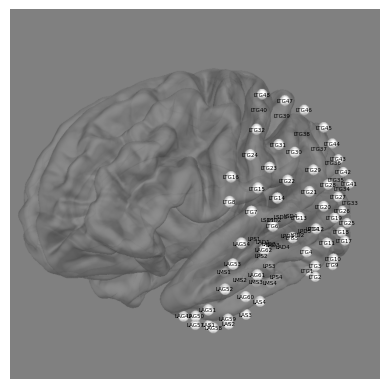

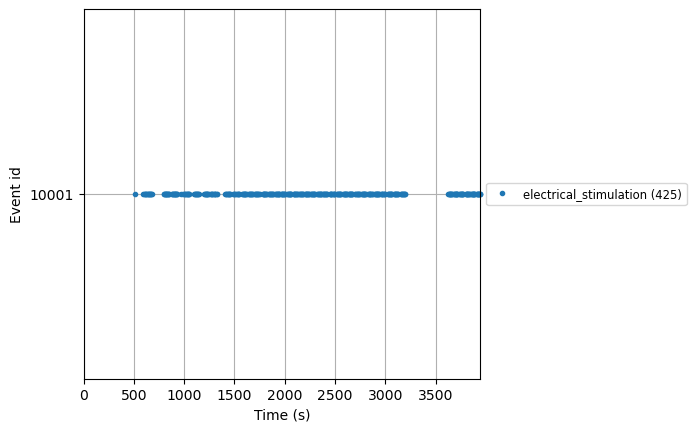

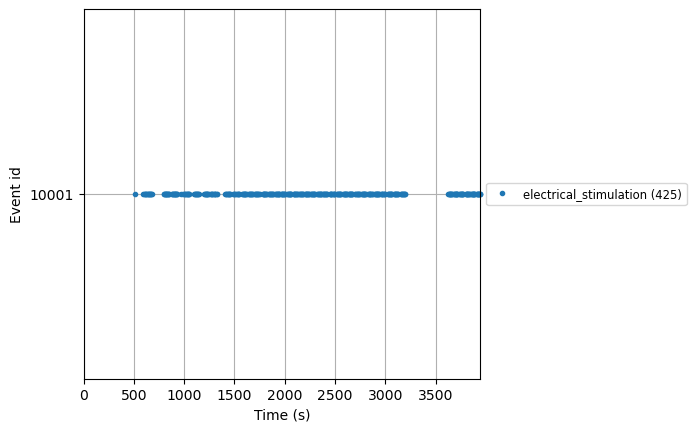

In [89]:
trans = mne.transforms.Transform(fro='head', to='mri', trans=np.eye(4))  # identity
fig = mne.viz.plot_alignment(
    raw.info, trans=trans, subject='fsaverage', surfaces='pial')
mne.viz.set_3d_view(fig, azimuth=150)

xy, im = mne.viz.snapshot_brain_montage(fig, raw.info)

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(im)
for name, pos in xy.items():
    if abs(pos[0]) < im.shape[0] and abs(pos[1]) < im.shape[1]:  # skip NaNs
        ax.text(*pos, name, ha='center', va='center', fontsize=4)
fig.show()

events, event_id = mne.events_from_annotations(raw)
mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id)

# 3. Preprocessing data

Look at the rendering with electrode labels and define the electrode of interest (e.g LMS2) and time window to be analyzed (e.g. -1,2)

In [90]:
# define electrode of interest
contact = 'LMS2'
# epoch_size for visualization
tmin, tmax = [-1,2]

events, event_id = mne.events_from_annotations(raw)

# try ``baseline=None`` for no baseline correction to play around
metadata = pd.read_csv(path.update(suffix='events'), sep='\t')
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, picks=[contact],
                    preload=True)
epochs.metadata = metadata  # contains stimulation location information
epochs = epochs[metadata.status == 'good']
tt = epochs.times

# unpack each pair separated by a hyphen, only use trials where
# stimulation was delivered to channels other than the channel of
# interest
epochs.metadata['site1'], epochs.metadata['site2'] = np.array([
    sites.split('-') for sites in
    epochs.metadata.electrical_stimulation_site]).T
exclude = np.in1d(epochs.metadata.site1, contact) | \
    np.in1d(epochs.metadata.site2, contact)
epochs = epochs[~exclude]

df_cceps = pd.DataFrame(columns = ['ccep_name_1', 'ccep_num_1', 'ccep_status_1', 'ccep_name_2', 'ccep_num_2', 'ccep_status_2'])

for index, row in epochs.metadata.iloc[:].iterrows():
    # Get stimulated channels
    trial_ccep_names = row.electrical_stimulation_site.split("-")
    curr_ccep = pd.DataFrame({ 'ccep_name_1': [trial_ccep_names[0]],
                               'ccep_name_2': [trial_ccep_names[1]],
                              })
    df_cceps = pd.concat([df_cceps, curr_ccep], ignore_index=True)

V_pre = epochs.get_data()[:, 0]  # select only channel

Used Annotations descriptions: ['electrical_stimulation']
Not setting metadata
425 matching events found
No baseline correction applied
0 projection items activated
Loading data for 425 events and 6145 original time points ...
0 bad epochs dropped
Adding metadata with 14 columns


## 3.3 Plot convergent matrix

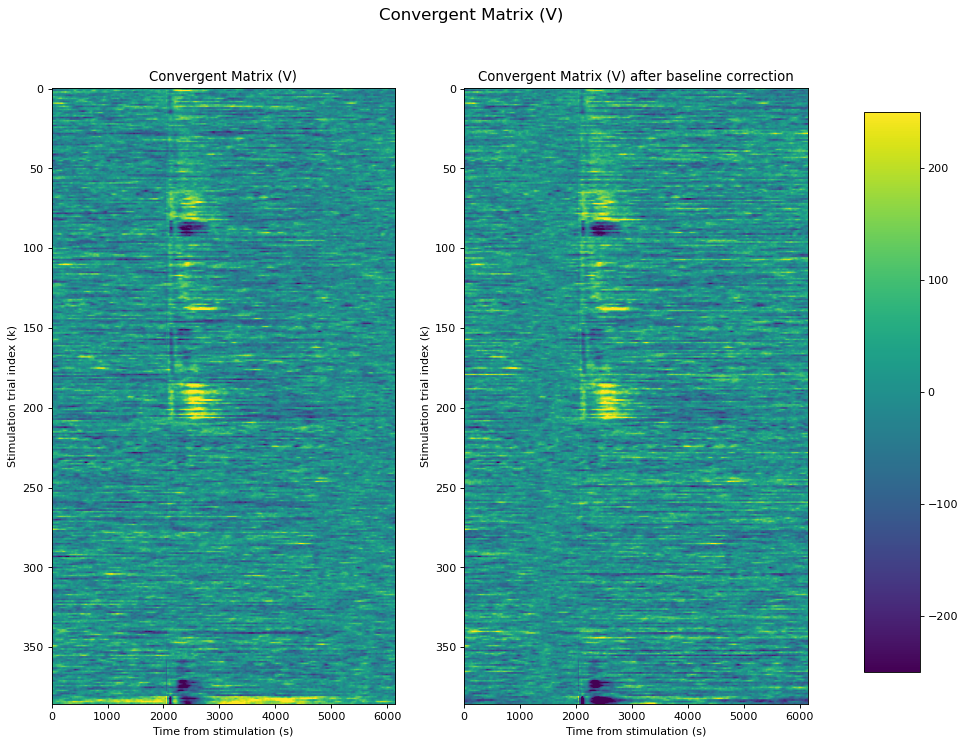

In [91]:
"""
Calculate baseline subtraction and plot difference
"""
V_pre = np.array(V_pre) * 1e6

# calculate baseline
baseline_V = np.mean(V_pre[:,np.logical_and(tt > -.5,tt < -0.05)],1)
# make baseline into the same size
baseline_Vrep = np.transpose(np.tile(baseline_V,(np.shape(tt)[0],1)))

# subtract baseline from V_pre
V_pre_baseSub = np.subtract(V_pre,baseline_Vrep)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), dpi=80)

fig.suptitle('Convergent Matrix (V)',fontsize= 15)
vmin=-250
vmax=250
im = ax1.imshow(V_pre, aspect='auto',vmin=vmin, vmax=vmax)
ax1.set_xlabel('Time from stimulation (s)')
ax1.set_ylabel('Stimulation trial index (k)')
ax1.set_title('Convergent Matrix (V)')
im = ax2.imshow(V_pre_baseSub, aspect='auto',vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time from stimulation (s)')
ax2.set_ylabel('Stimulation trial index (k)')
ax2.set_title('Convergent Matrix (V) after baseline correction')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# 4. Calculate BPCs

Identifying basis profile curves (BPCs) that group characteristic shapes in the convergent CCEPs. 

The input for the BPC calculation is the convergent matrix (V_pre, numpy array), the time vector (tt, numpy array), and the pandas dataframe pair_types that we will generate in this section.

## 4.1 Select time-frame for BPC extraction

In [92]:
# select the epoch times to enter in the BPC analyses in seconds
bpc_tmin, bpc_tmax = [0.015, 1]

## 4.2 Calculate the significance matrix

To calculate the significance matrix, we project the unit-normalized stimulation trials into all other trials. We then calculate t-values across all subgroups of stimulation pairs.

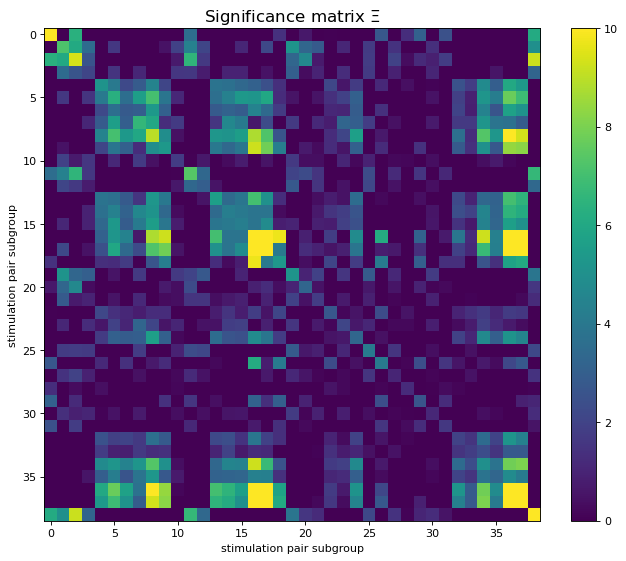

In [100]:
pair_types = df_cceps.groupby(['ccep_name_1', 'ccep_name_2']).size().reset_index().rename(columns={0: 'count'})
pair_types = pair_types.sort_values(by=['ccep_name_1']) 

indices_column = []
for index, row in pair_types.iterrows():
    indices_column.append(df_cceps.index[(df_cceps['ccep_name_1'] == row['ccep_name_1']) & (df_cceps['ccep_name_2'] == row['ccep_name_2'])].tolist())
pair_types['indices'] = indices_column


V = epochs.get_data(tmin=bpc_tmin, tmax=bpc_tmax)[:, 0].T # select only channel
V0 = V / np.linalg.norm(V, axis=0)  # L2 norm each trial
P = V0.T @ V  # calculate internal projections

pairs = np.unique(epochs.metadata.electrical_stimulation_site)
tmat = np.zeros((len(pairs), len(pairs)))
for i, pair1 in enumerate(pairs):
    mask = epochs.metadata.electrical_stimulation_site == pair1
    b = P[np.ix_(mask, mask)].ravel()
    tmat[i, i] = np.mean(b) / np.std(b, ddof=1) * np.sqrt(len(b))
    for j, pair2 in enumerate(pairs[i + 1:]):
        b = P[np.ix_(epochs.metadata.electrical_stimulation_site == pair1,
                     epochs.metadata.electrical_stimulation_site == pair2)].ravel()
        tmat[i + j + 1, i] = np.mean(b) / np.std(b, ddof=1) * np.sqrt(len(b))

# copy to lower
tmat = tmat + tmat.T - np.diag(np.diag(tmat))

# visualize the set of native normalized single stimulation cross-projections 
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(tmat,aspect='auto') # Plot a matrix or an array as an image.
plt.clim(0, 10)
plt.ylabel('stimulation pair subgroup')
plt.xlabel('stimulation pair subgroup')
plt.title('Significance matrix '+r'$\Xi$',fontsize= 15)
plt.colorbar()

plt.show()

## 4.3 Iteratively decrease inner components of non-negative matrix factorization

Using Non-Negative Matrix Factorization (NMF) on the significance matrix to cluster sites that produce similar measured responses.

In [ ]:
"""
Find two non-negative matrices (W, H) whose product approximates the factorize, 
non-negative and rescaled matrix (t0_scaled). 
At the end, the matrix H has size of number of clusters by stimulation pair sub-groups.
"""

#### Default settings and initialization

# number of cluster dimensions
cl_dim = 10
    
# number of iterations to re-run NNMF - because can get suboptimal factorization due to non-unique nature of NNMF (starts out with a random matrix)
num_reruns = 20

# convergence threshold: 1e-5
conv_thresh = 0.00001

t0 = tmat
t0[t0 < 0] = 0 # factorize t-matrix, but first make non-negative

# Globally rescale data to avoid potential overflow/underflow
t0_scaled = t0 / (np.max(t0))    

nnmf_xcorr_score = 100  # start off-diagonal penalty score out with high value

WH_struct = pd.DataFrame(columns=['W', 'H', 'nnmf_xcorr_score'])  # saving structure

#### Do the NMF

#while nnmf_xcorr_score >. 5:
while nnmf_xcorr_score > 0.9:
  
    cl_dim = cl_dim - 1 # reduce number of inner dimensions
    
    if cl_dim == 0:
        break

    # multiple run-throughs of  nnmf
    tmp_mat_W = []
    tmp_mat_H = []
    tmp_err = []

    for k in range(num_reruns):

        model = NMF(n_components=cl_dim, init='random', solver='mu',tol=conv_thresh,max_iter=10000)
        W = model.fit_transform(t0_scaled)
        tmp_mat_W.insert(k, W)
    
        H = model.components_
        tmp_mat_H.insert(k, H)

        rec_err = model.reconstruction_err_
        tmp_err.insert(k, rec_err)

    # select factorization with smallest error
    k_ind = np.argmin(tmp_err)    
    W_min = tmp_mat_W[k_ind]
    H_min = tmp_mat_H[k_ind]

    # Normalize so rows of H have unit norm
    Hnorms = np.sqrt(np.sum(H_min.T ** 2, axis=0))
    Hnorms_ = (np.reshape(np.tile(Hnorms.T, t0_scaled.shape[1]),(-1, Hnorms.shape[0]))).T
    H_min = H_min / Hnorms_

    # Score for this decomposition - off diagonal element weights
    HHT = H_min @ H_min.T
    HHT_triu = np.triu(HHT, 1)
    HHT_triu_reshaped = np.reshape(HHT_triu, (1,-1))
    # nnmf_xcorr_score = np.max(HHT_triu_reshaped) # max of nonnegative matrix factorization component interdependencies
    nnmf_xcorr_score = np.sum(HHT_triu_reshaped) # sum of off-diagonal nonnegative matrix factorization component interdependencies
    print('Inner dimension: ', cl_dim, ', off diagonal score: ', nnmf_xcorr_score)

    # save matrices and scores for plotting later
    curr_WH = pd.DataFrame({'W': [W_min], 'H': [H_min], 'nnmf_xcorr_score': [nnmf_xcorr_score]})
    WH_struct = pd.concat([WH_struct, curr_WH], ignore_index=True)

## 4.4 Winner take all

Each stimulation pair subgroup is assigned to one cluster.

In [95]:
"""
winner-take-all on columns of H and then threshold by 1/(2*sqrt(length(pair_types))) 
 -- since all equal would be 1/sqrt(length(pair_types))
"""

H0 = 0 * H_min

for k in range(len(pairs)):
    k_ind = np.argmax(H_min, axis=0)[k]
    H0[k_ind][k] = H_min[k_ind][k]

H0_ = H0 > 1 / (2 * np.sqrt(len(pairs)))

## 4.5 Identification of Basis Profile Curves 

BPCs are identified from the clustered groups (rows of H) using linear kernel PCA.

In [98]:
"""
output will show the subgroup numbers clustered in each BPC
"""

B = []
B_struct = pd.DataFrame(columns=['curve','pairs']) # saving structure

for q in range(H0.shape[0]):
    cl_pg = np.where(H0_[q]) # cluster pair groups
    cl_inds = [] # cluster indices (e.g. concatenated trials from cluster pair groups)
    for k in cl_pg:
        for i in (pair_types['indices'][k]).values:
            cl_inds.extend(i)

    V_tmp = V[:, cl_inds]

    E = pyBPCs.kpca(V_tmp)
    B_tmp = E[:, 0] # basis vector is 1st PC

    if np.mean(B_tmp.T @ V_tmp) < 0:
        B_tmp = -B_tmp
    
    curr_B = pd.DataFrame({'curve': [B_tmp], 'pairs': [cl_pg[0]]})
    B_struct = pd.concat([B_struct, curr_B], ignore_index=True)
    
# pairs not represented by any basis
excluded_pairs = np.where(1 - (np.sum(H0_, axis=0)))

"""
Calculate statistics for each basis curve, eliminating those where there is no significant representation
"""

B_struct = pyBPCs.curvesStatistics(B_struct, V, B, pair_types)

"""
Calculate projection weights
"""

B_struct = pyBPCs.projectionWeights(B_struct)

B_struct.pairs

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 386 is different from 2018)

# 5. Visualize BPCs

## 5.1 Plot Calculated BPCs

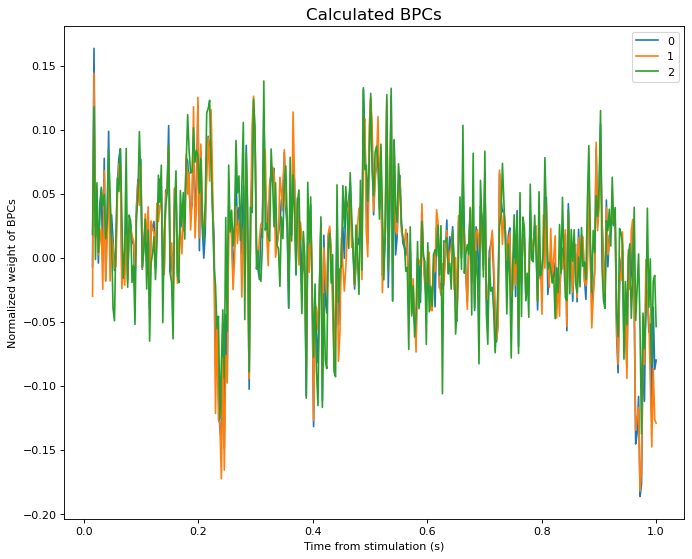

In [97]:
colors = iter(cm.tab10(np.linspace(0, 1, 10)))

bpc_tt = np.linspace(bpc_tmin, bpc_tmax, B_struct.curve[0].shape[0])
plt.figure(figsize=(10, 8), dpi=80)
for q in range(len(B_struct)): #  cycle through basis curves
    plt.plot(bpc_tt, B_struct.curve[q], color=next(colors), label=q)
    
plt.xlabel('Time from stimulation (s)')
plt.ylabel('Normalized weight of BPCs')
plt.title('Calculated BPCs',fontsize=15)
plt.legend()

plt.show()

## 5.2 Spatial representation of the BPCs

In [ ]:
marker_colors = [] # marker_color array
marker_sizes = [] # marker_size array

# all electrodes
xyz = df_electrodes[['x', 'y','z']]
xyz_list = xyz.values.tolist()
electrodeName_list = df_electrodes[['name']].name.values.tolist()
for cords in xyz_list:
    marker_colors.append('white')
    marker_sizes.append(7.5)

# el_interest
xyz_el_interest = df_electrodes.loc[df_electrodes.name == el_interest_nr.name.values[0]][['x', 'y','z']]
xyz_list.append(xyz_el_interest.values[0].tolist())
marker_colors.append('black')
marker_sizes.append(20)

pair_types['interpolated_locs'] = ''

for index, row in pair_types.iterrows():
    xyz_1 = xyz.iloc[row['ccep_num_1']].values.tolist()
    xyz_2 = xyz.iloc[row['ccep_num_2']].values.tolist()
    pair_types.at[index, 'interpolated_locs'] = np.mean((xyz_1, xyz_2), axis=0).tolist()

# non-significant stim pair sites    
interpolated_locs_list = pair_types.iloc[excluded_pairs[0]].interpolated_locs.values.tolist()
for cords in interpolated_locs_list:
    marker_colors.append('gray')
    marker_sizes.append(7.5)
    
xyz_all = [y for x in [xyz_list, interpolated_locs_list] for y in x]

# plot BPCs, colored
colors = iter(cm.tab10(np.linspace(0, 1, 10)))

for q in range(B_struct.shape[0]):
    # get electrodes for BPC
    xyz_BPC_list = pair_types.interpolated_locs[B_struct.pairs[q]].tolist()
    xyz_all = [y for x in [xyz_all, xyz_BPC_list] for y in x]
    plotweights = B_struct.plotweights[q]
    curr_color = next(colors)
    for ind_cords in range(len(xyz_BPC_list)):
        marker_colors.append(curr_color)
        marker_sizes.append(B_struct.plotweights[q][ind_cords] * 25)

# plot all
view = plotting.view_markers(marker_coords=xyz_all,marker_size=marker_sizes, # marker_labels=electrodeName_list,
                             marker_color=marker_colors, title='Spatial representation of BPCs rendered on an MNI brain') # Insert a 3d plot of markers in a brain
view.open_in_browser()

## 5.3 Optional parameters to change

Once you have completed this, you can go back to Section 4.1 and change the time interval over which the BPCs are calculated (e.g. 0.2 - 1 sec) and look at the effects on the outputs.

You can also select a different electrode in Section 3 to look at the various inputs into different regions.